# 9.0 Performance Programming

*Estimated time for this notebook: 10 minutes*

We've spent most of this course looking at how to make code readable and reliable. For research work, it is often also important that code is efficient: that it does what it needs to do *quickly*.

It is very hard to work out beforehand whether code will be efficient or not: it is essential to *profile* code, to measure its performance, to determine what aspects of it are slow.

## 9.0.1 Motivation

First, we'll need some code to profile. Let's consider the series

$z_{i+1}=z_{i}^2$, starting from $z_0=c$, where $c$ is a real number and $i = 1, 2, 3, \dots$.

In [1]:
def series1(start, iterations=4):
    """Returns the value of the series after the provided number of iterations."""
    value = start
    for _ in range(iterations):
        value = value**2

    return value


assert series1(0) == 0
assert series1(1) == 1
assert series1(-2) == 65536

Let's look at the values of series after 4 iterations for different starting points.

In [2]:
xmin = -2
xmax = 2
resolution = 300
xstep = (xmax - xmin) / resolution
xs = [(xmin + (xstep * i)) for i in range(resolution)]  # list of starting points

In [3]:
zs = [series1(x) for x in xs]

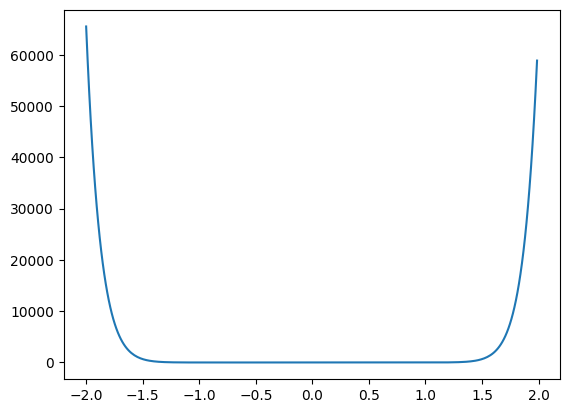

In [4]:
import matplotlib.pyplot as plt

plt.plot(xs, zs)

Note how quickly the series grows outside of +/- 1.

In practice, it is probably a good idea to have a way of stopping the function early (i.e., before we reach the maximum number of iterations) when we notice that the values are exploding. So we need to pick a threshold and tell our function to stop once the value of the series surpasses this threshold. For now (and without obvious reason) we pick 2 as our threshold. It would be interesting to know if the function computed all iterations or stopped early (and if so, how early). We can easily get this information by modifying the return value of our function.

In [5]:
def series2(start, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.

    The function stops when the value of the series surpasses a threshold or when it reaches the maximum
    number of iterations.

    Returns the number of iterations.
    """
    value = start

    counter = 0

    while counter < max_iterations:
        # Arbitrary threshold, for now
        if abs(value) > 2:
            break

        value = value**2

        counter = counter + 1

    return counter


assert series2(0) == 50
assert series2(1) == 50
assert series2(2) == 1
assert series2(1.5) == 1

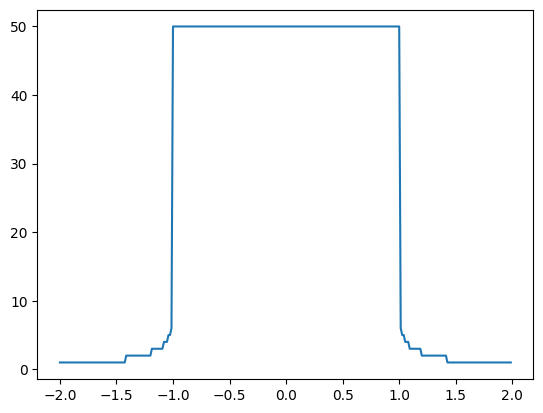

In [6]:
zs = [series2(x) for x in xs]
plt.plot(xs, zs)

We can generalise this to complex numbers.
A complex number $c$, for example $c = 5 + 6 \cdot j$, has a real part $Re(c) = 5$ and an imaginary part $Im(c) = 6$. 
The definition of the imaginary unit $j$ is given by $j = \sqrt{-1}$.
Note that we use the $j$ (instead of $i$) as it is common for engineers and this is the convention that Python follows.

There's more than one way to make a complex number in Python.

In [7]:
# Option 1
c = complex(5, 6)

In [8]:
# Option 2
d = 5 + 1j * 6

We can visualise complex numbers by plotting them in a 2D coordinate system, where the x-axis denotes the real part and the y-axis the imaginary part. Let's do that for our example $c = 5 + 6 \cdot j$. The distance from the origin is the _absolute value_ of the complex number which we compute as $\sqrt{Re(c)^2 + Im(c)^2}$.

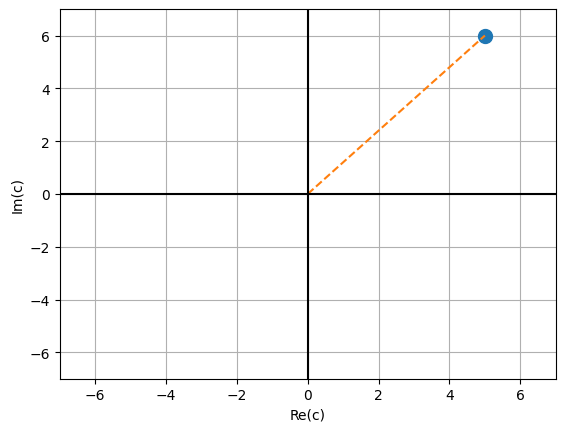

In [9]:
plt.plot(c.real, c.imag, marker="o", markersize=10)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.plot([0, c.real], [0, c.imag], "--")
plt.plot([-7, 7], [0, 0], color="black")
plt.plot([0, 0], [-7, 7], color="black")
plt.grid()

In [10]:
# absolute value (distance from origin)
abs(c)

7.810249675906654

Back to our series. We want to apply our function on different complex starting points and visualise the result. 
This means we need to change our line plot to a 2D heatmap.

In [11]:
# we need some complex starting points
xmin = -3
ymin = -3
xmax = 3
ymax = 3
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
zs = [[series2(x + y * 1j) for x in xs] for y in ys]

Questions for you: 
- How would you describe the data structure of `zs`?
- How many complex numbers are in the list `zs`?

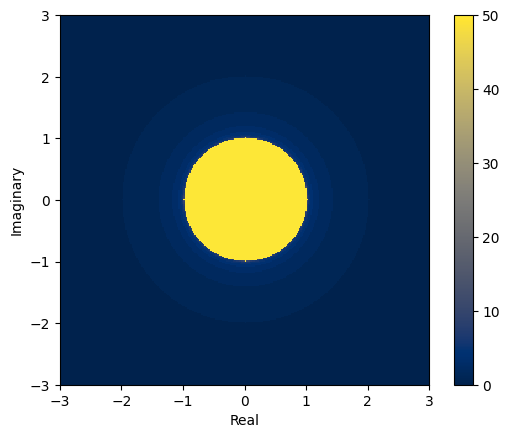

In [12]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(zs, interpolation="none", extent=[xmin, xmax, ymin, ymax], origin="lower")
plt.colorbar()

We see that there is a circle of radius 1 so we know that series will diverge whenever the start point is further than 1 from the origin.

## 9.0.2 Mandelbrot Set


Things get much more interesting when we change the series from

$z_{i+1}=z_{i}^2$ (with $z_0=c$)

to 

$z_{i+1}=z_{i}^2 + c$, starting from $z_0 = 0$, where $c$ is a complex constant and $i = 1, 2, 3, \dots$.

In [13]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.

    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum
    number of iterations.

    Returns the number of iterations.
    """

    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value**2) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

Let's plot the heatmap for the new series.

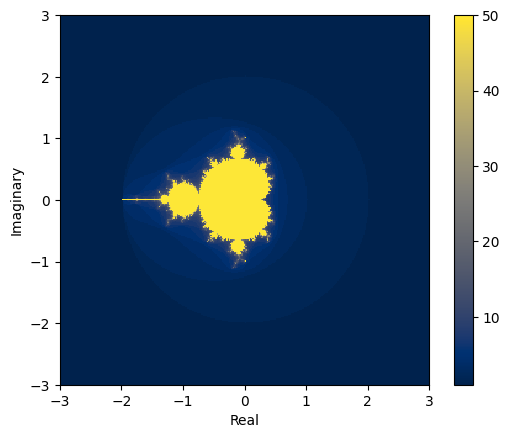

In [14]:
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    [[mandel(x + y * 1j) for x in xs] for y in ys],
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower",
)
plt.colorbar()

<div class="alert alert-block alert-info">  The Mandelbrot set consists of all values of complex numbers $c$ for which the series $z_{i+1} = z_i^2 + c$ does not diverge to infinity when iterated from the seed $z_0 = 0$. 
    
It can be proven that if there is an $i$ for which $|z_i| > 2$, then the sequence tends to infinity. </div>

## 9.0.3 Fractals

The yellow area are those complex values for which the series hasn't exploded. The values within the yellow area form the Mandelbrot set. 

It was first defined and drawn by Robert W. Brooks and Peter Matelski in 1978 but is named after Benoit Mandelbrot, who obtained high quality visualizations of it, in 1980, while working at IBM's Thomas J. Watson Research Center.

The boundary of the Mandelbrot set is a fractal. **Fractals** are geometrical patterns that are **self-similar** at different scales, which means that every part of a fractal, no matter how much we zoom in, looks similar to the whole. 
It's easier to understand what that means by looking at some examples:

In [15]:
xmin = -1
ymin = -1
xmax = 0
ymax = 0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
zs = [[mandel(x + y * 1j) for x in xs] for y in ys]

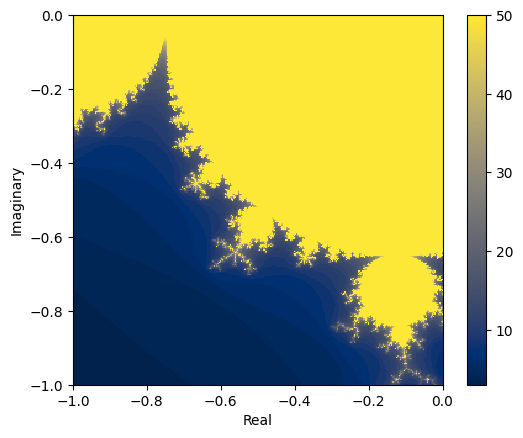

In [16]:
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(zs, interpolation="none", extent=[xmin, xmax, ymin, ymax], origin="lower")
plt.colorbar()

Here's a nice visualisation for this on [Wikipedia](https://commons.wikimedia.org/wiki/File:Mandelbrot_sequence_new.gif#/media/File:Mandelbrot_sequence_new.gif).

## 9.0.4 Timing

For the rest of this module, we will focus on the  `mandel()` function and try to speed up our initial implementation. If we want to get an idea for how fast or slow our code is, we need a way to time how long it takes to run.
We can use the `%%timeit` magic in a notebook to time a cell.

In [17]:
%%timeit?

In [18]:
%%timeit -n 3 -r 7 value=10
# timeit results are only useful as comparisons
# the absolute values are not meaningful
# variables created in timeit cells aren't available outside
value**value

467 ns ± 152 ns per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [19]:
%%timeit
[[mandel(x + y * 1j) for x in xs] for y in ys]

989 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our Mandelbrot function will loop up to 50 times for each number in our grid, which is resolution * resolution in size. You cannot calculate the set in it's entirety as there are infinitely many complex numbers. You need to recalculate the set/fractal for your region of interest.

The performance of our function is limited by how quickly we can do calculations on the CPU. This isn't always the case and other functions could be limited by reading/writing data to a network or storage. Depending on the bottleneck, the techniques we cover in this module might not always work to speed up code.